# Simple SARIMA

This code template is for Time Series Analysis and Forecasting to make scientific predictions based on historical time stamped data with the help of SARIMA algorithm

### Required Packages

In [33]:
import warnings 
import numpy as np
import pandas as pd 
import seaborn as se 
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error 

warnings.filterwarnings("ignore")


### Initialization

Filepath of CSV file

In [34]:
file_path = ""

Variable containing the date time column name of the Time Series data

In [35]:
date = ""

Target feature for prediction.

In [36]:
target = ""

### Data Fetching

Pandas is an open-source, BSD-licensed library providing high-performance, easy-to-use data manipulation and data analysis tools.

We will use panda's library to read the CSV file using its storage path.And we use the head function to display the initial row or entry.

In [37]:
df = pd.read_csv(file_path)
df.head()

,date,sales
0,01-01-2013,14236.90
1,01-02-2013,4519.89
2,01-03-2013,55691.01
3,01-04-2013,28295.35
4,01-05-2013,23648.29


### Data Preprocessing

Since the majority of the machine learning models for Time Series Forecasting doesn't handle string category data and Null value, we have to explicitly remove or replace null values. The below snippets have functions, which removes the rows containing null value if any exists. And convert the string classes date column in the datasets to proper Date-time classes.

After the proper date conversions are done and null values are dropped, we set the Date column as the index value.


In [38]:
def data_preprocess(df, target, date):
    df = df.dropna(axis=0, how = 'any')
    df[date] = pd.to_datetime(df[date])
    df = df.set_index(date)
    return df

In [39]:
df = data_preprocess(df,target,date)
df.head()

,sales
date,
2013-01-01,14236.90
2013-01-02,4519.89
2013-01-03,55691.01
2013-01-04,28295.35
2013-01-05,23648.29


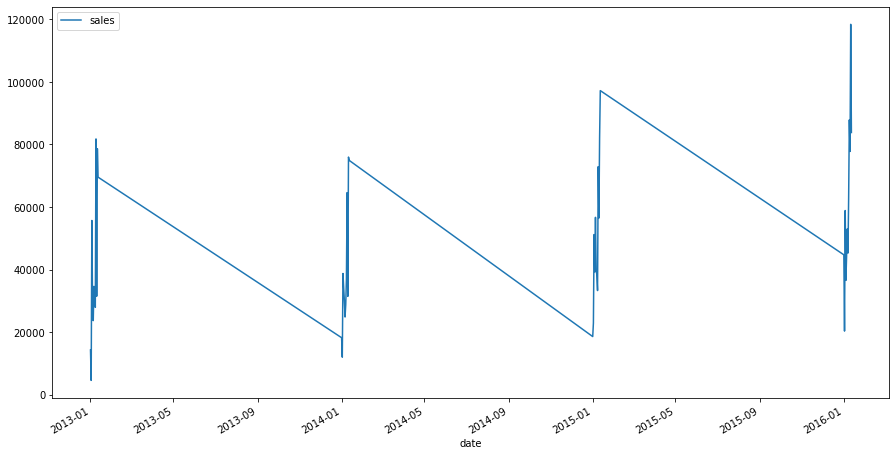

In [40]:
df.plot(figsize = (15,8))
plt.show()

### Seasonality decomposition

Since Simple ARIMAX for non-seasonal data, we need to check for any seasonality in our time series and decompose it.

We use the Dickey Fuller Test for testing the seasonality and if the ADF Statistic value is positive, it means that the data has seasonality.

#### Dickey Fuller Test
The Dickey Fuller test is a common statistical test used to test whether a given Time series is stationary or not. The Augmented Dickey Fuller (ADF) test expands the Dickey-Fuller test equation to include high order regressive process in the model. We can implement the ADF test via the **adfuller()** function. It returns the following outputs:

    1. adf : float
> The test statistic.

    2. pvalue : float
> MacKinnon's approximate p-value based on MacKinnon(1994, 2010). It is used alongwith the test statistic to reject or accept the null hypothesis.

    3. usedlag : int
> Number of lags considered for the test

    4. critical values : dict
> Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).

For more information on the adfuller() function [click here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

In [41]:
def dickeyFuller(df,target):
    
    # Applying Dickey Fuller Test
    X = df.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Number of lags used: %d' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
           print('\t%s: %.3f' % (key, value))    
    return df

In [42]:
df = dickeyFuller(df,target)

ADF Statistic: -4.481467
p-value: 0.000212
Number of lags used: 0
Critical Values:
	1%: -3.578
	5%: -2.925
	10%: -2.601


### Autocorrelation Plot


We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.
A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. 

An autocorrelation plot shows whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 
The plot shows the value of the autocorrelation function (acf) on the vertical axis ranging from –1 to 1.
There are vertical lines (a “spike”) corresponding to each lag and the height of each spike shows the value of the autocorrelation function for the lag.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)

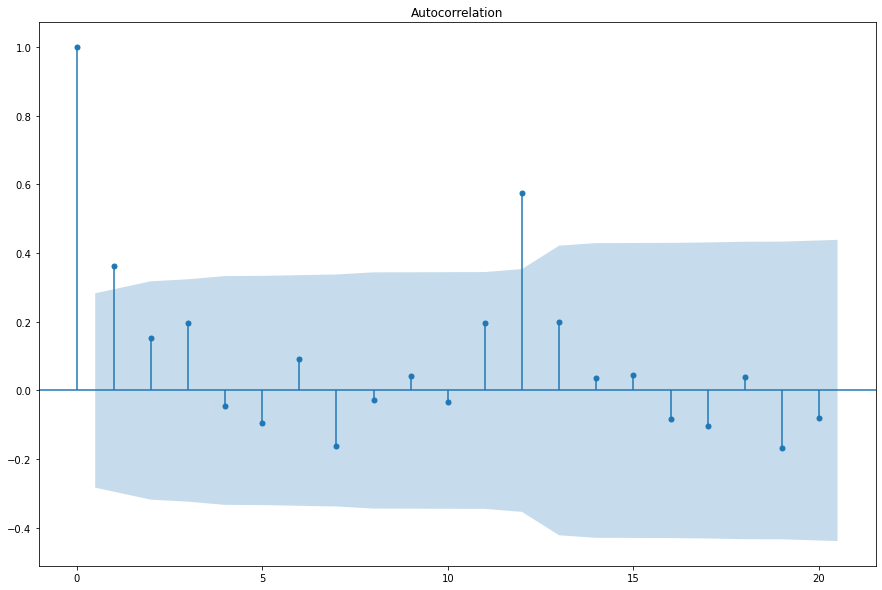

In [67]:
x = plot_acf(df, lags=20)
x.set_size_inches(15, 10, forward=True)
plt.show()

### Partial Autocorrelation Plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags. By examining the spikes at each lag we can determine whether they are significant or not. A significant spike will extend beyond the significant limits, which indicates that the correlation for that lag doesn't equal zero.

[API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)


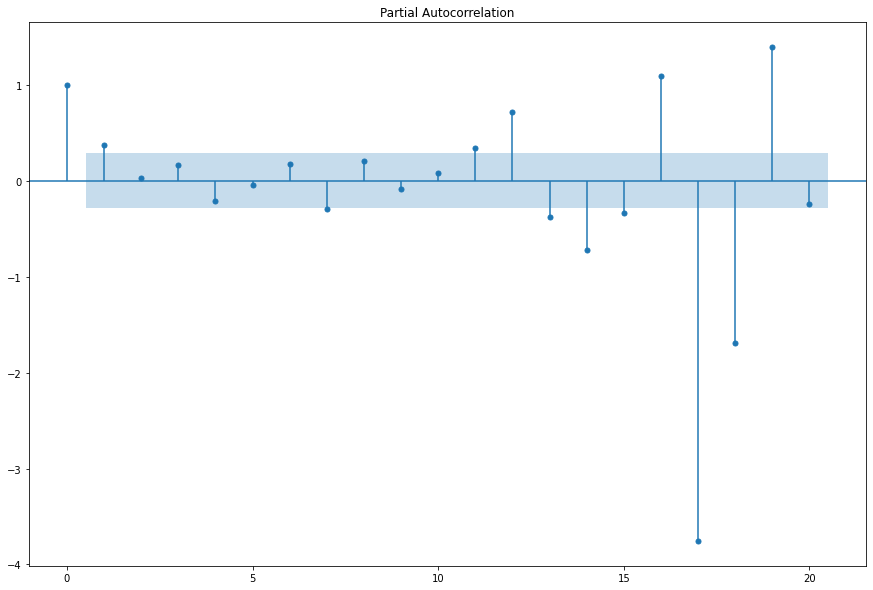

In [68]:
y = plot_pacf(df, lags=20)
y.set_size_inches(15, 10, forward=True)
plt.show()

### Data Splitting

Since we are using a univariate dataset, we can directly split our data into training and testing subsets. The first subset is utilized to fit/train the model. The second subset is used for prediction. The main motive is to estimate the performance of the model on new data.

In [69]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

### Model
## SARIMA
SARIMA(Seasonal Auto-Regressive Integrated Moving Average) method is used for time series forecasting with univariate data containing trends and seasonality.
#### Model Tuning Parameters

    1. endog: array_like
>The observed time-series process 

    2. exog: array_like, optional
>Array of exogenous regressors, shaped nobs x k.

    3. order: iterable or iterable of iterables, optional
>The (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).

    4. seasonal_order: iterable, optional
>The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. D must be an integer indicating the integration order of the process, while P and Q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.

    5. trend: str{‘n’,’c’,’t’,’ct’} or iterable, optional
>Parameter controlling the deterministic trend polynomial . Can be specified as a string where ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both. Can also be specified as an iterable defining the non-zero polynomial exponents to include, in increasing order. For example, [1,1,0,1] denotes 
. Default is to not include a trend component.

    6. measurement_error: bool, optional
>Whether or not to assume the endogenous observations endog were measured with error. Default is False.

    7. time_varying_regression: bool, optional
>Used when an explanatory variables, exog, are provided provided to select whether or not coefficients on the exogenous regressors are allowed to vary over time. Default is False.

    8. mle_regression: bool, optional
>Whether or not to use estimate the regression coefficients for the exogenous variables as part of maximum likelihood estimation or through the Kalman filter (i.e. recursive least squares). If time_varying_regression is True, this must be set to False. Default is True.

Refer to the official documentation at [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) for more parameters and information

In [70]:
model=SARIMAX(df[target],order=(1, 0, 0),seasonal_order=(0,0,0,0))
result=model.fit()

### Model Summary

After fitting the training data into our ARIMAX and training it, we can take a look at a brief summary of our model by using the **summary()** function. The followings aspects are included in our model summary:

1. Basic Model Details: The first column of our summary table contains the basic details regarding our model such as: 
    
        a. Name of dependent variable    
        b. Model used along with parameters    
        c. Date and time of model deployment    
        d. Time Series sample used to train the model
    
        
2. Probablistic Statistical Measures: The second column gives the values of the probablistic measures obtained by our model:
    
       a. Number of observations
   
       b. Log-likelihood, which comes from Maximum Likelihood Estimation, a technique for finding or optimizing the
       parameters of a model in response to a training dataset.
   
       c. Standard Deviation of the innovations
   
       d. Akaike Information Criterion (AIC), which is derived from frequentist probability.
   
       e. Bayesian Information Criterion (BIC), which is derived from Bayesian probability.
   
       f. Hannan-Quinn Information Criterion (HQIC), which is an alternative to AIC and is derived using the log-likelihood and 
       the number of observartions.
   
   
   
3. Statistical Measures and Roots: The summary table also consists of certain other statistical measures such as z-value, standard error as well as the information on the characteristic roots of the model.

In [71]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   48
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -558.075
Date:                Thu, 30 Sep 2021   AIC                           1120.150
Time:                        17:16:50   BIC                           1123.892
Sample:                             0   HQIC                          1121.564
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8726      0.070     12.474      0.000       0.735       1.010
sigma2      7.263e+08   4.32e-12   1.68e+20      0.000    7.26e+08    7.26e+08
===================================================================================
Ljung-Box (L1) (Q):                   7.89   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.00   Prob(JB):                         0.83
Heteroskedasticity (H):               0.92   Skew:                            -0.01
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

#### Simple Forecasting

In [72]:
df_train.tail()

,sales
date,
2016-01-03,58872.35
2016-01-04,36521.54
2016-01-05,44261.11
2016-01-06,52981.73
2016-01-07,45264.42


### Predictions

By specifying the start and end time for our predictions, we can easily predict the future points in our time series with the help of our model.

In [73]:
d = df.drop([target], axis = 1)

start_date = d.iloc[size].name
end_date = d.iloc[len(df)-1].name

df_pred = result.predict(start = start_date, end = end_date)
df_pred.head()

date
2016-01-08     39497.344655
2016-01-09     55078.747221
2016-01-10     76671.685150
2016-01-11     67867.473293
2016-01-12    103356.560521
Name: predicted_mean, dtype: float64

## Model Accuracy

We will use the three most popular metrics for model evaluation: Mean absolute error (MAE), Mean squared error (MSE), or Root mean squared error (RMSE).

In [74]:
test = df_test[target]
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(test,df_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(test,df_pred)))
print("Root Mean Squared Error {:.2f}".format(np.sqrt(mean_squared_error(test,df_pred))))

Mean Absolute Error 25524.86
Mean Squared Error 914805122.88
Root Mean Squared Error 30245.75


## Predictions Plot

First we make use of plot to plot the predicted values returned by our model based on the test data.
After that we plot the actual test data to compare our predictions.

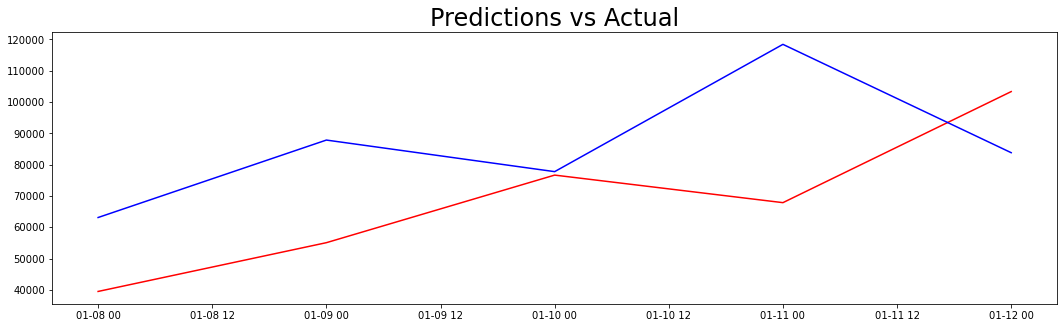

In [75]:
plt.figure(figsize=(18,5))
plt.plot(df_pred[start_date:end_date], color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")

plt.show()

#### Creator: Akshar Nerkar, Github: [Profile](https://github.com/Akshar777)